In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves


[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 4393 (delta 1457), reused 1401 (delta 1401), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 37.59 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [2]:
# Get Data for ViT Architecture


# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [3]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [4]:
from torchvision import transforms
from going_modular.going_modular import data_setup

IMG_SIZE = 224
BATCH_SIZE = 32

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

train_dataloader, test_dataloader,class_names= data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

In [5]:
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [6]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label


(torch.Size([3, 224, 224]), tensor(1))

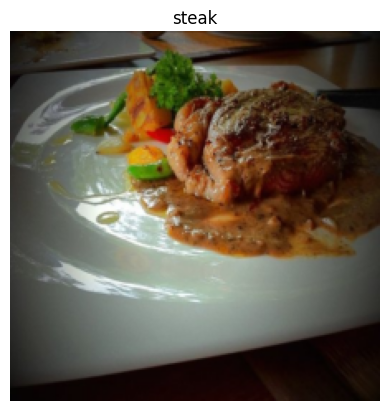

In [7]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

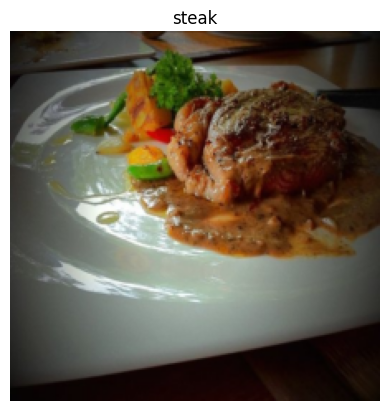

In [8]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [9]:
image.shape

torch.Size([3, 224, 224])

In [10]:
image_permuted = image.permute(1, 2, 0)
patch_size = 16
image_permuted.shape


torch.Size([224, 224, 3])

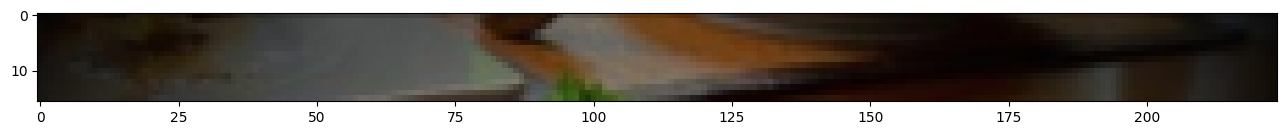

In [11]:
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

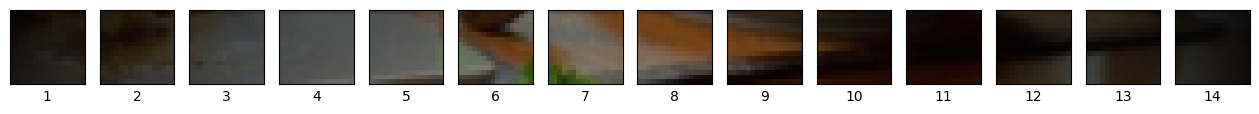

In [12]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

# Create a series of Subplots
fig, axs = plt.subplots(nrows=1,
                       ncols=img_size // patch_size,
                       sharex=True,
                       sharey=True,
                       figsize=(patch_size, patch_size))

# Iterate through the number of patches in the top row
for i, patch in enumerate(range(0,img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0  
Number of patches per column: 14.0  
Total Patches: 196.0  
Patch Size:16pixels x 16pixels


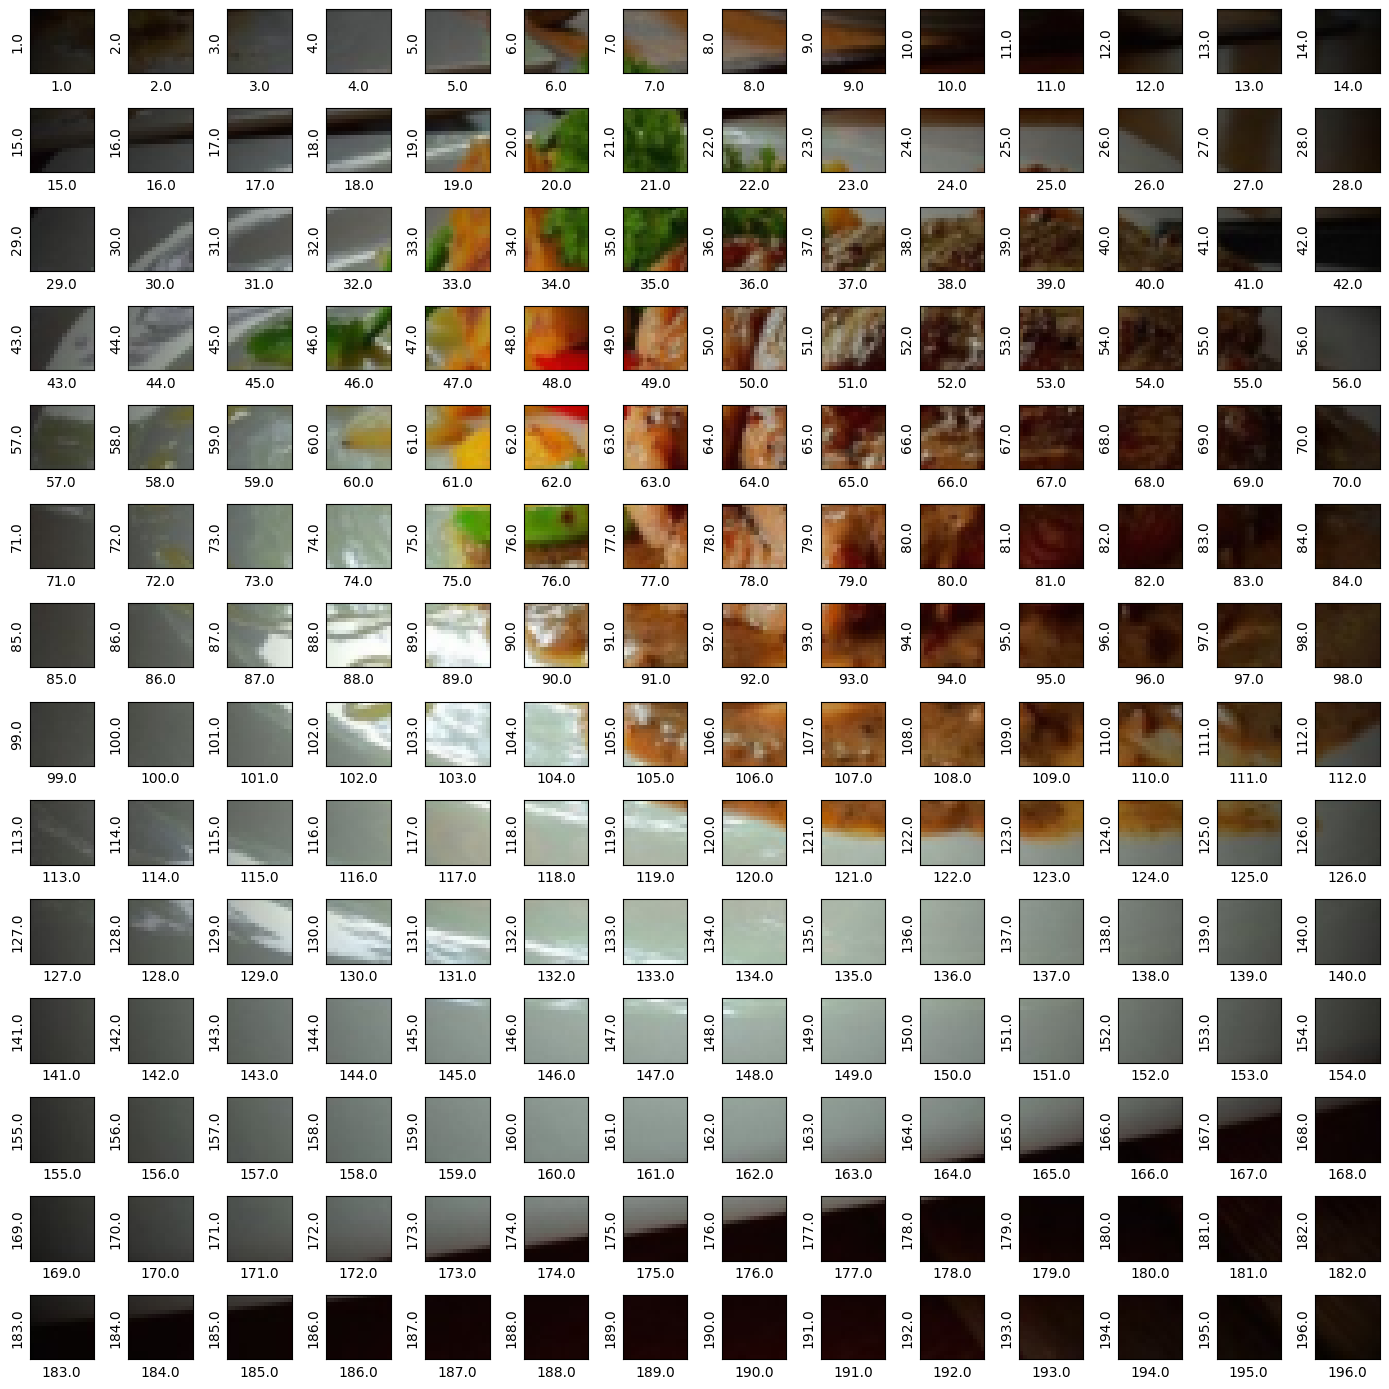

In [13]:
# Setup for whole image as patches

img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
  \nNumber of patches per column: {num_patches}\
  \nTotal Patches: {num_patches*num_patches}\
  \nPatch Size:{patch_size}pixels x {patch_size}pixels")

# Create a series of Subplots
fig, axs = plt.subplots(nrows=img_size //patch_size,
                        ncols=img_size //patch_size,
                        figsize=(num_patches,num_patches),
                        sharex=True,
                        sharey=True)

for i,patch_height in enumerate(range(0,img_size,patch_size)):
  for j,patch_width in enumerate(range(0,img_size,patch_size)):
    axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,patch_width:patch_width+patch_size,:])
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].set_xlabel(f"{i*num_patches+j+1}")
    axs[i,j].set_ylabel(f"{i*num_patches+j+1}")
plt.tight_layout()
plt.show()


In [14]:
#Creating Image Patches and turning them into Patch Embeddings

from torch import nn

patch_size=16
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

conv2d


Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

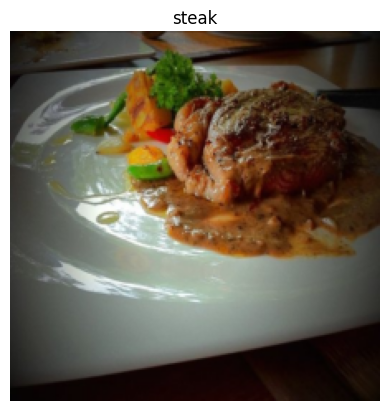

In [15]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [16]:
image_out_of_conv = conv2d(image.unsqueeze(dim=0))
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

Showing random Convolutional feature maps :[376, 388, 294, 324, 214]


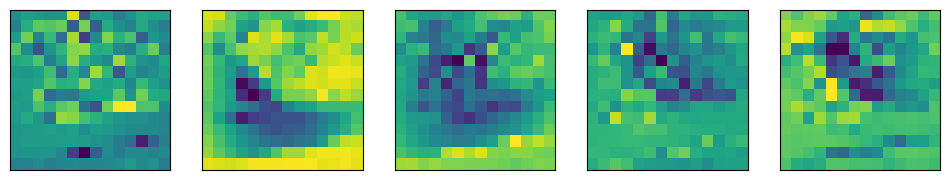

In [17]:
import random
random_indexes = random.sample(range(0,758),k=5)
print(f"Showing random Convolutional feature maps :{random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

for i, idx in enumerate(random_indexes):
  image_conv_feature_map= image_out_of_conv[:, idx, :, :]
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set_xticks([])
  axs[i].set_yticks([])


In [18]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[0.0655, 0.1071, 0.1793, 0.2425, 0.2720, 0.1818, 0.3078, 0.2706,
           0.1403, 0.0687, 0.0407, 0.0457, 0.1206, 0.0670],
          [0.0666, 0.1325, 0.1955, 0.1855, 0.2671, 0.2180, 0.1520, 0.3369,
           0.3589, 0.3181, 0.2152, 0.1738, 0.1261, 0.1093],
          [0.1334, 0.2966, 0.3064, 0.3445, 0.4010, 0.3090, 0.1804, 0.1376,
           0.2715, 0.2148, 0.1856, 0.1898, 0.0484, 0.0865],
          [0.1850, 0.3888, 0.3404, 0.3303, 0.4437, 0.3677, 0.3803, 0.2502,
           0.2812, 0.2481, 0.1780, 0.1602, 0.1245, 0.1621],
          [0.1722, 0.3072, 0.3699, 0.3715, 0.5013, 0.5691, 0.4212, 0.3761,
           0.2676, 0.1541, 0.1475, 0.1256, 0.0777, 0.1092],
          [0.1755, 0.2775, 0.3380, 0.4887, 0.4918, 0.1948, 0.3947, 0.4035,
           0.3515, 0.2361, 0.1349, 0.0743, 0.0505, 0.0940],
          [0.1777, 0.2635, 0.3150, 0.6286, 0.5822, 0.5224, 0.3665, 0.3440,
           0.3055, 0.1761, 0.1367, 0.1245, 0.1356, 0.1453],
          [0.1883, 0.2467, 0.3098, 0.5793, 0.5687, 0.62

In [19]:
from torch import nn
flatten_layer= nn.Flatten(start_dim=2,
                          end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


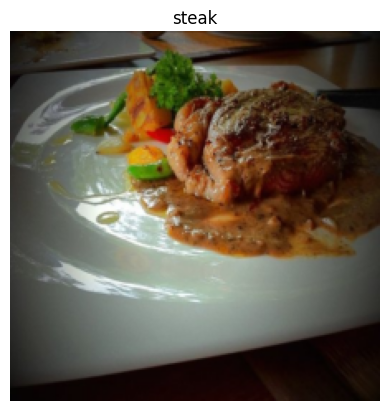

In [20]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [21]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


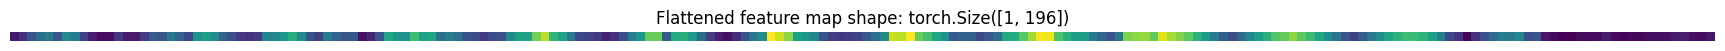

In [22]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);


In [23]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels: int = 3,
               patch_size: int = 16,
               embedding_dim: int = 768):
    super().__init__()
    self.patch_size= patch_size

    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    self.flatten= nn.Flatten(start_dim=2,
                             end_dim=3)

  def forward(self, x):
    image_resolutions = x.shape[-1]
    assert image_resolutions % self.patch_size == 0, "Image size must be divisible by patch size"
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    return x_flattened.permute(0,2,1)

In [24]:
set_seeds()

patchify = PatchEmbedding(in_channels=3,
                         patch_size=16,
                         embedding_dim=768)

print(f"Input image size:{image.unsqueeze(0).shape}")
patch_embedded_image= patchify(image.unsqueeze(0))
print(f"Output image size:{patch_embedded_image.shape}")

Input image size:torch.Size([1, 3, 224, 224])
Output image size:torch.Size([1, 196, 768])


In [25]:
# Creating Class Token Embedding

patch_embedded_image.shape

torch.Size([1, 196, 768])

In [26]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[2]
batch_size, embedding_dimension

(1, 768)

In [27]:
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [28]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [29]:
patch_embedded_image_with_class_embedding= torch.cat((class_token, patch_embedded_image), dim=1)
patch_embedded_image_with_class_embedding.shape
print(patch_embedded_image_with_class_embedding)

tensor([[[ 0.5436, -0.4700, -1.2133,  ..., -0.4571,  0.4486,  0.1217],
         [-0.1362,  0.0362, -0.0603,  ...,  0.0932, -0.0200,  0.0238],
         [-0.1384,  0.0425, -0.1123,  ...,  0.1227, -0.0623,  0.0711],
         ...,
         [-0.0641, -0.0172, -0.0395,  ...,  0.0335, -0.0239,  0.0326],
         [-0.0473,  0.0114, -0.0350,  ...,  0.0144, -0.0261,  0.0226],
         [-0.0860,  0.0017, -0.0281,  ...,  0.0453, -0.0432,  0.0219]]],
       grad_fn=<CatBackward0>)


In [30]:
# Position embedding

patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [31]:
number_of_patches = int((patch_height * patch_width)/ patch_size**2)
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]
embedding_dimension, number_of_patches
position_embedding = nn.Parameter(torch.randn(1,
                                              197,
                                              embedding_dimension),
                                  requires_grad=True)
position_embedding.shape,position_embedding

(torch.Size([1, 197, 768]),
 Parameter containing:
 tensor([[[-1.0264, -2.4631,  0.1703,  ...,  0.1468,  1.3768,  0.5802],
          [-0.6950,  0.7188, -1.1410,  ..., -0.3153, -2.2221, -0.6922],
          [-1.5855, -0.3176, -1.4012,  ...,  1.7983,  0.5078,  0.0315],
          ...,
          [ 1.2855,  0.8303,  0.1497,  ..., -0.4751,  1.2664,  0.6758],
          [-0.0406, -0.5170, -0.3489,  ..., -0.4922,  0.3503,  1.3471],
          [-0.2454, -0.0047,  1.4984,  ..., -0.4075,  1.5785, -0.3281]]],
        requires_grad=True))

In [32]:
patch_and_position_embedding= patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding.shape,patch_and_position_embedding

(torch.Size([1, 197, 768]),
 tensor([[[-0.4828, -2.9331, -1.0430,  ..., -0.3104,  1.8254,  0.7019],
          [-0.8312,  0.7551, -1.2012,  ..., -0.2220, -2.2422, -0.6684],
          [-1.7239, -0.2751, -1.5135,  ...,  1.9209,  0.4455,  0.1026],
          ...,
          [ 1.2214,  0.8131,  0.1101,  ..., -0.4416,  1.2424,  0.7084],
          [-0.0880, -0.5056, -0.3839,  ..., -0.4778,  0.3241,  1.3697],
          [-0.3314, -0.0030,  1.4704,  ..., -0.3622,  1.5353, -0.3061]]],
        grad_fn=<AddBackward0>))

In [33]:
set_seeds()
patch_size = 16
print(f"Image Tensor Shape: {image.shape}")
height, width = image.shape[1], image.shape[2]
print(f"Image Height: {height} Image Width: {width}")

x = image.unsqueeze(0)
print(f"Image unsqueezed shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

patch_embedding = patch_embedding_layer(x)
print(f"Image embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[2]
batch_size, embedding_dimension
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
patch_embedding_class_token.shape

number_of_patches = int((height * width)/ patch_size**2)
position_embedding = nn.Parameter(torch.ones(1,number_of_patches+1,embedding_dimension),
                                  requires_grad=True)
position_embedding.shape

patch_and_position_embedding = patch_embedding_class_token + position_embedding
patch_and_position_embedding.shape


Image Tensor Shape: torch.Size([3, 224, 224])
Image Height: 224 Image Width: 224
Image unsqueezed shape: torch.Size([1, 3, 224, 224])
Image embedding shape: torch.Size([1, 196, 768])


torch.Size([1, 197, 768])

In [34]:
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               attn_dropout:int=0):
    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True)
  def forward(self,x):
    x = self.layer_norm(x);
    attn_output, _ =self.multihead_attn(query = x,
                                      key = x,
                                      value=x,
                                      need_weights=False)
    return attn_output

In [35]:
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
patched_image_through_msa_block.shape

torch.Size([1, 197, 768])

In [36]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:float=0.1):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape= embedding_dim)
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [37]:
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
patched_image_through_mlp_block.shape

torch.Size([1, 197, 768])

In [38]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768, # Hidden size D from table 1, 768 for ViT-Base
               num_heads:int=12, # from table 1
               mlp_size:int=3072, # from table 1
               mlp_dropout:int=0.1, # from table 3
               attn_dropout:int=0):
    super().__init__()

    # Create MSA block (equation 2)
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    # Create MLP block (equation 3)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x # residual/skip connection for equation 2
    x = self.mlp_block(x) + x # residual/skip connection for equation 3
    return x

In [39]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [40]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [41]:
# Get a summary using torchinfo.summary
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

In [42]:
# Putting it all together

class ViT(nn.Module):
  def __init__(self,
               img_size:int=224,
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12,
               embedding_dim:int=768,
               num_heads:int=12,
               mlp_size:int=3072,
               attn_dropout:int=0,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1,
               num_classes:int=1000):
    super().__init__()

    assert img_size % patch_size == 0, "Image size must be divisible by patch size"
    # Create a patch embedding layer
    self.num_patches = (img_size * img_size) // patch_size ** 2
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)
    self.position_embedding = nn.Parameter(data=torch.randn(1,self.num_patches+1, embedding_dim))

    self.embedding_dropout = nn.Dropout(p=embedding_dropout)
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    batch_size = x.shape[0]
    class_token = self.class_embedding.expand(batch_size, -1, -1)
    x = self.patch_embedding(x)
    x = torch.cat((class_token, x), dim=1)
    x = x + self.position_embedding
    x = self.embedding_dropout(x)
    x = self.transformer_encoder(x)
    x = self.classifier(x[:, 0])
    return x


In [43]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

In [44]:
set_seeds()

random_image_tensor = torch.randn(1, 3, 224, 224)
vit = ViT(num_classes=1000)
vit(random_image_tensor)

tensor([[ 6.7808e-02,  1.1918e+00,  1.1203e+00, -3.8994e-01, -7.3035e-01,
          3.6647e-01, -4.5606e-01,  2.0491e-01, -3.2757e-01, -5.4101e-03,
          4.9439e-01,  4.5225e-01, -7.3808e-01, -7.9905e-03, -9.9846e-01,
         -4.7147e-01, -3.6692e-01, -9.6623e-01,  4.7522e-01,  2.8831e-01,
         -2.3278e-02,  6.1200e-01,  3.1616e-02, -8.2726e-01,  7.9415e-01,
         -5.1114e-02,  3.9171e-01,  4.7158e-01, -3.3682e-01, -2.9868e-01,
         -1.6136e-01,  1.0612e-02,  3.1002e-01,  1.8962e-01,  9.6459e-03,
         -1.9699e-01,  1.2877e-01, -2.3558e-03, -6.0887e-01,  8.0185e-02,
         -9.0505e-01, -1.0530e+00, -1.9897e-01, -5.3337e-01, -2.7275e-01,
         -2.3806e-01, -1.5176e-01, -7.3394e-01,  6.2018e-01,  1.9093e-02,
         -8.3832e-01, -5.3223e-01,  9.1586e-01,  2.1562e-01,  4.9433e-01,
         -9.8498e-01,  1.3858e-01, -2.0809e-01, -1.2675e+00,  6.8107e-01,
          8.2911e-02,  1.7974e-01, -4.3775e-01, -1.2672e+00,  2.7665e-01,
         -4.6644e-01, -6.0426e-01,  8.

In [45]:
# Getting a Summary of the Model
from torchinfo import summary
summary(model=vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params","trainable"],
        col_width=10,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape Output Shape Param #    Trainable
ViT (ViT)                                                    [1, 3, 224, 224] [1, 1000]  152,064    True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224] [1, 196, 768] --         True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224] [1, 768, 14, 14] 590,592    True
│    └─Flatten (flatten)                                     [1, 768, 14, 14] [1, 768, 196] --         --
├─Dropout (embedding_dropout)                                [1, 197, 768] [1, 197, 768] --         --
├─Sequential (transformer_encoder)                           [1, 197, 768] [1, 197, 768] --         True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768] [1, 197, 768] --         True
│    │    └─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768] [1, 197, 768] 2,363,904  True
│    │    └─MLPBlock (mlp_block)             

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [47]:
# Training our ViT Model

from going_modular.going_modular import engine

set_seeds()


optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)





  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8524 | train_acc: 0.2617 | test_loss: 1.1693 | test_acc: 0.2491
Epoch: 2 | train_loss: 1.2720 | train_acc: 0.3047 | test_loss: 2.3406 | test_acc: 0.2604
Epoch: 3 | train_loss: 2.0376 | train_acc: 0.3047 | test_loss: 1.0857 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.4687 | train_acc: 0.2617 | test_loss: 1.6275 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.5211 | train_acc: 0.2773 | test_loss: 1.0878 | test_acc: 0.5417
Epoch: 6 | train_loss: 1.2962 | train_acc: 0.3086 | test_loss: 1.9100 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.3541 | train_acc: 0.4375 | test_loss: 3.0531 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.6554 | train_acc: 0.2891 | test_loss: 1.4856 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1971 | train_acc: 0.4258 | test_loss: 1.1128 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.3900 | train_acc: 0.2656 | test_loss: 1.2851 | test_acc: 0.2604


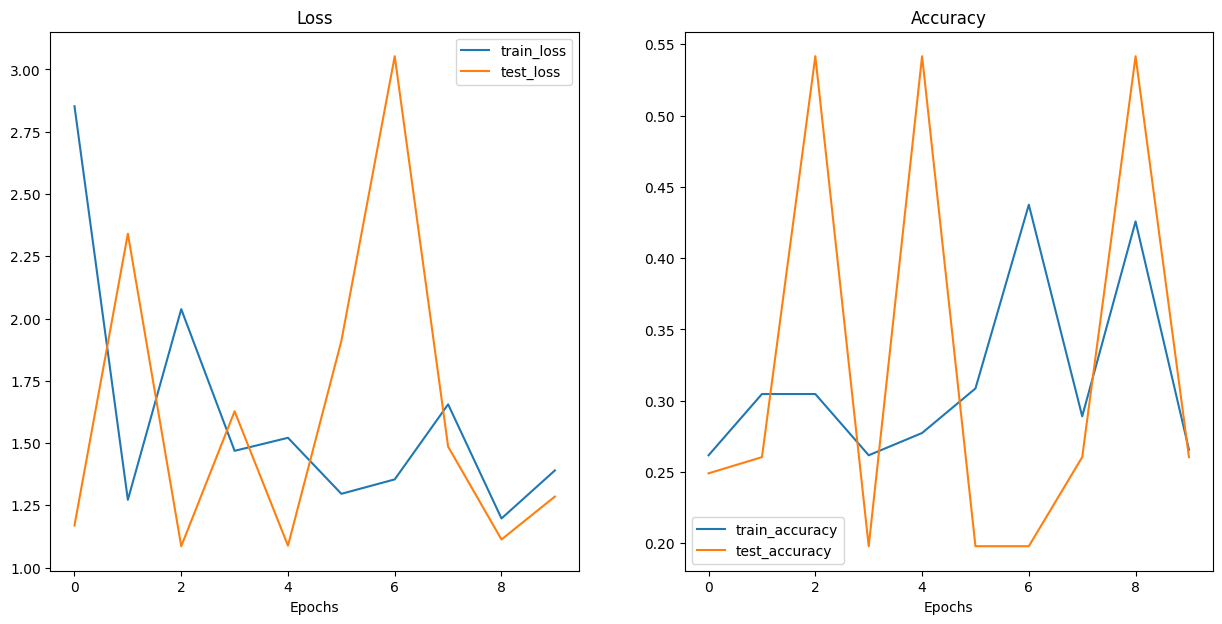

In [48]:
# Plotting loss curves

from helper_functions import plot_loss_curves
plot_loss_curves(results)

In [49]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [50]:
pretrained_vit_weights= torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit= torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)
pretrained_vit

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 73.5MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [51]:
for param in pretrained_vit.parameters():
  param.requires_grad=False

pretrained_vit.heads= nn.Linear(in_features=768,
                                out_features=3).to(device)



In [52]:
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [53]:
from going_modular.going_modular import data_setup


train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir = test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32)


In [54]:
from going_modular.going_modular import engine

set_seeds()
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()
pretrained_vit_results= engine.train(model=pretrained_vit,
                                     train_dataloader=train_dataloader_pretrained,
                                     test_dataloader=test_dataloader_pretrained,
                                     epochs=10,
                                     loss_fn=loss_fn,
                                     optimizer=optimizer,
                                     device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7371 | train_acc: 0.7305 | test_loss: 0.4698 | test_acc: 0.8883
Epoch: 2 | train_loss: 0.3187 | train_acc: 0.9648 | test_loss: 0.2950 | test_acc: 0.9688
Epoch: 3 | train_loss: 0.1850 | train_acc: 0.9688 | test_loss: 0.2481 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1381 | train_acc: 0.9727 | test_loss: 0.2212 | test_acc: 0.9384
Epoch: 5 | train_loss: 0.1101 | train_acc: 0.9727 | test_loss: 0.2099 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.1142 | train_acc: 0.9766 | test_loss: 0.2027 | test_acc: 0.9384
Epoch: 7 | train_loss: 0.0832 | train_acc: 0.9805 | test_loss: 0.2330 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0714 | train_acc: 0.9883 | test_loss: 0.2250 | test_acc: 0.8883
Epoch: 9 | train_loss: 0.0995 | train_acc: 0.9883 | test_loss: 0.2009 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0577 | train_acc: 0.9922 | test_loss: 0.1757 | test_acc: 0.9479


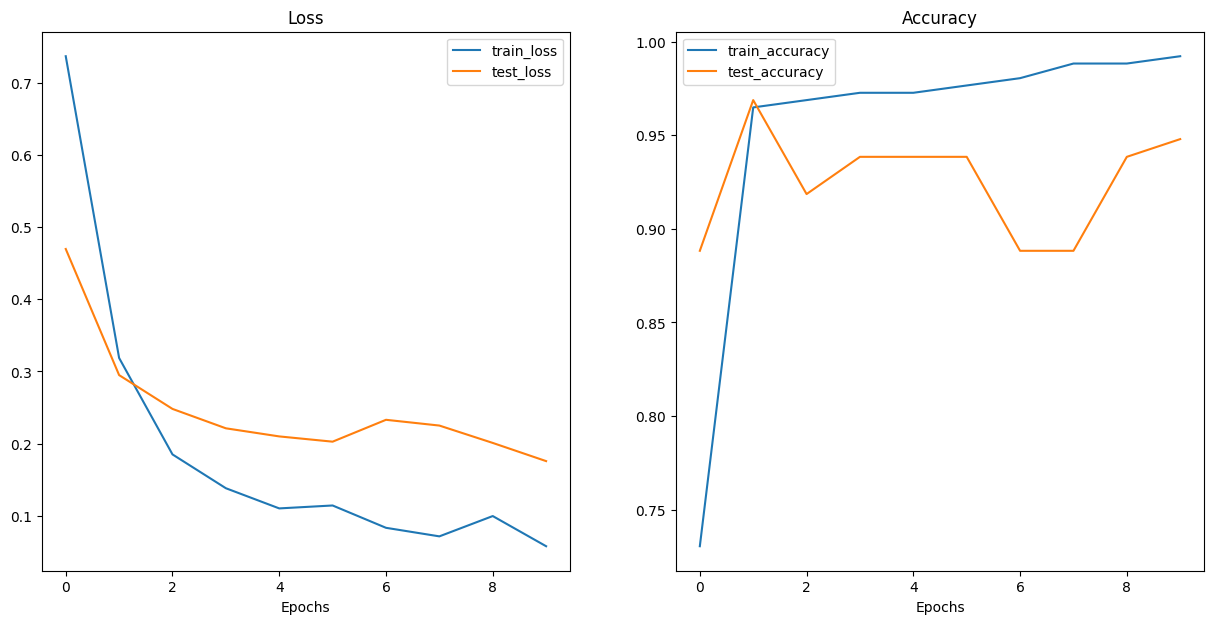

In [55]:
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_results)

In [57]:
# Save the model
from going_modular.going_modular import utils
utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")


[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [58]:
from pathlib import Path

pretrained_vit_model_size= Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")
pretrained_vit_model_size.stat().st_size/1024/1024


327.36915016174316